# Encoder

In [ ]:
# !unzip '/content/CSE256_PA2_FA24.zip'

In [ ]:
import nltk
# nltk.download('punkt')

In [ ]:
import sys
sys.path.append('/content/CSE256_PA2_FA24/PA2_code')

In [ ]:
import torch
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
import os
import torch.nn as nn
import math
import torch.nn.functional as F


from utilities import Utilities

from tokenizer import SimpleTokenizer
from dataset import SpeechesClassificationDataset, LanguageModelingDataset


seed = 42

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = "cpu"

In [ ]:
""" Hyperparameters to use for training to roughly match
the numbers mentioned in the assignment description """
batch_size = 16  # Number of independent sequences will we process in parallel
block_size = 32  # Maximum context length for predictions                         # max_seq_len
learning_rate = 1e-3  # Learning rate for the optimizer
n_embd = 64  # Embedding dimension                                                # d_model
n_head = 2  # Number of attention heads                                           # n_h
n_layer = 4  # Number of transformer layers                                       # N


eval_interval = 100  # How often to evaluate train and test perplexity during training
max_iters = 500 # For language modeling, we can process all the batches for the entire dataset, but that takes a while, so we'll limit it to 500 iterations. For batch size of 16 and block size of  32, this is roughly, this is  500 * 16 * 32 = 256000 tokens, SOTA LMs are trained on trillions of tokens, so this is a very small dataset.
eval_iters = 200  # Number of iterations to evaluate perplexity on the test set


## classifier training hyperparameters. It is a simple 1 hidden layer feedforward network, with input
## size of 64, hidden size of 50 and output size of 3.

n_input = 64  # Input size for the classifier, should match the embedding size of the transformer
n_hidden = 100  # Hidden size for the classifier
n_output = 3  # Output size for the classifier, we have 3 classes
epochs_CLS = 15 # epochs for classifier training

In [ ]:
def compute_accuracy(output, target):
    ########### TODO ###########

    predicted = output.argmax(dim=1)

    # Calculate accuracy by comparing predicted labels with target labels
    correct = (predicted == target).sum()#.item()
    total = target.size(0)
    acc = correct / total

    ######## End of TODO #######
    return acc

In [ ]:
def load_texts(directory):
    """
    This function loads all texts from the specified directory, ignoring any files with "test" in their name. The text is used for "training" the tokenizer. Since our tokenizer is simple, we don't need to do any training, but we still need to ignore the test data.
    """

    texts = []
    files = os.listdir(directory)
    for filename in files:
        if "test" in filename:  ## don't "read test files"
            continue
        with open(os.path.join(directory, filename), 'r', encoding='utf-8') as file:
            texts.append(file.read())
    return texts



def collate_batch(batch):
    """ Collate a batch of data into a single tensor with padding."""
    data, labels = zip(*batch)  # Separate the data and labels
    # Pad sequences to the fixed length
    padded_sequences = pad_sequence(data, batch_first=True, padding_value=0)
    padded_sequences = padded_sequences[:, :block_size]  # Truncate if longer
    # Add padding if shorter
    padded_sequences = torch.nn.functional.pad(padded_sequences, (0, max(0, block_size - padded_sequences.shape[1])), "constant", 0)
    labels = torch.stack(labels)
    return padded_sequences, labels

def compute_classifier_accuracy(classifier, data_loader):
    """ Compute the accuracy of the classifier on the data in data_loader."""
    classifier.eval()
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
        for X, Y in data_loader:
            X, Y = X.to(device), Y.to(device)
            outputs = classifier(X)
            _, predicted = torch.max(outputs.data, 1)
            total_correct += (predicted == Y).sum().item()
            total_samples += Y.size(0)
        accuracy = (100 * total_correct / total_samples)
        classifier.train()
        return accuracy


def compute_perplexity(decoderLMmodel, data_loader, eval_iters=100):
    """ Compute the perplexity of the decoderLMmodel on the data in data_loader.
    Make sure to use the cross entropy loss for the decoderLMmodel.
    """
    decoderLMmodel.eval()
    losses= []
    total_loss = 0
    for X, Y in data_loader:
        X, Y = X.to(device), Y.to(device)
        # me
        #loss = decoderLMmodel(X, Y) # your model should be computing the cross entropy loss
        loss = decoderLMmodel(X, Y)[2] # your model should be computing the cross entropy loss
        # me
        losses.append(loss.item())
        total_loss += loss.item()
        if len(losses) >= eval_iters: break


    losses = torch.tensor(losses)
    mean_loss = losses.mean()
    perplexity = torch.exp(mean_loss).item()  # Calculate perplexity as exp(mean loss)

    decoderLMmodel.train()
    return perplexity

In [ ]:
# Example usage
texts = load_texts('/content/CSE256_PA2_FA24/PA2_code/speechesdataset')
tokenizer = SimpleTokenizer(' '.join(texts))  # Create a tokenizer from the data

train_CLS_dataset = SpeechesClassificationDataset(tokenizer, "/content/CSE256_PA2_FA24/PA2_code/speechesdataset/train_CLS.tsv")


# # get dataset
# texts = load_texts('/home/vsahu/private/CSE/CSE256_PA_SP24/speechesdataset')
# tokenizer = SimpleTokenizer(' '.join(texts)) # create a tokenizer from the data

# train_CLS_dataset = SpeechesClassificationDataset(tokenizer, "/home/vsahu/private/CSE/CSE256_PA_SP24/speechesdataset/train_CLS.tsv")
train_CLS_loader = DataLoader(train_CLS_dataset, batch_size=batch_size, collate_fn=collate_batch)

test_CLS_dataset = SpeechesClassificationDataset(tokenizer, "/content/CSE256_PA2_FA24/PA2_code/speechesdataset/test_CLS.tsv")
test_CLS_loader = DataLoader(test_CLS_dataset, batch_size=batch_size, collate_fn=collate_batch)

In [ ]:
train_CLS_dataset[50]

(tensor([2241, 2370, 4577, 4534,  883, 1986,  830, 2283, 3693, 3317, 1660, 1499,
         1429, 4577, 4969, 3705, 1986, 5377,  893]),
 tensor(2))

In [ ]:
class Embedder(nn.Module):

    def __init__(self, vocab_size, d_model):
        super(Embedder, self).__init__()
        self.embed = nn.Embedding(vocab_size, d_model)

    def forward(self, x):
        #x = x.to(device)
        return self.embed(x)

In [ ]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_seq_length):
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]



In [ ]:
class MultiHeadAttention(nn.Module):

    def __init__(self, d_model, num_heads, dropout=0.2):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0

        self.d_model = d_model # Model's dimension
        self.num_heads = num_heads # Number of attention heads
        self.d_k = d_model // num_heads # Dimension of each head's key, query, and value

        self.W_q = nn.Linear(d_model, d_model) # Query transformation
        self.W_k = nn.Linear(d_model, d_model) # Key transformation
        self.W_v = nn.Linear(d_model, d_model) # Value transformation
        self.W_o = nn.Linear(d_model, d_model) # Output transformation
        self.dropout = nn.Dropout(dropout)

    def split_heads(self, x):
        # Reshape the input to have num_heads for multi-head attention
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2) # similar to np reshape

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        attn_scores = torch.matmul(Q,K.transpose(-2, -1))/math.sqrt(self.d_k)

        #print('attn_scores', attn_scores.shape)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9) # inbuilt function of tensor
        attn_probs = torch.softmax(attn_scores, dim = -1) # for each row
        output = torch.matmul(attn_probs, V)
        return output, attn_probs

    def combine_heads(self, x):
        # Combine the multiple heads back to original shape
        batch_size, _, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)

    def forward(self, Q, K, V, mask=None):
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))

        # Perform scaled dot-product attention
        attn_output, attn_probs = self.scaled_dot_product_attention(Q, K, V, mask)

        # Combine heads and apply output transformation
        output = self.W_o(self.combine_heads(attn_output))
        #print('attention size', type(attn_probs), attn_probs.shape)
        output = self.dropout(output)
        return output, attn_probs




In [ ]:
class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff): # d_ff: Dimensionality of the inner layer in the feed-forward network.

        super(PositionWiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

In [ ]:
class EncoderBlock(nn.Module):

    def __init__(self, d_model, num_heads, d_ff, max_seq_length, dropout):
        super(EncoderBlock, self).__init__()
        #self.self_attention = MultiHeadAttention(d_model, num_heads)
        self.self_attention = MHAttention(
                                input_size=block_size, # Dimension 1 of the input
                                channels=n_embd, # Dimension 2 of the input
                                dim=32, # Dim of each attn head
                                dim_k=block_size//32, # What to sample the input length down to
                                nhead=n_head, # Number of heads
                                dropout=0, # Dropout for each of the heads
                                activation=None, #"gelu", # Activation after attention has been concat'd
                                checkpoint_level="C2", # If C2, checkpoint each of the heads
                                parameter_sharing='none', #"layerwise", # What level of parameter sharing to do
                                E_proj=None, #get_EF(512, 128),
                                F_proj=None, #get_EF(512, 128), # The E and F projection matrices
                                full_attention=False, # Use full attention instead
                                causal_mask = gen_causal_mask(block_size, block_size//32, full_attention=False),
                                w_o_intermediate_dim=None)

        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.layernorm0 = nn.LayerNorm(d_model)
        self.layernorm1 = nn.LayerNorm(d_model)
        self.layernorm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):

        x1 = self.layernorm0(x)
        #attn_output, attn_probs = self.self_attention(x1,x1,x1,mask) #  the entire forward pass through the MultiHeadAttention module is executed
        #  The padding mask ensures that these padded tokens are not attended to during the self-attention step. This mask is a binary matrix where the entry is 1 if the corresponding input token is not a padding token and 0 if it is a padding token. During self-attention, the padding mask is added to the scaled dot-product attention operation to exclude padded elements from contributing to the attention scores.
        attn_output = self.self_attention(x1) #  the entire forward pass through the MultiHeadAttention module is executed
        attn_probs = attn_output
        x = x + attn_output
        x2 = self.layernorm1(x)
        ff = self.feed_forward(x2)
        x = self.layernorm2(self.dropout(ff)+x)
        # how pointwise is taken care of?


        return x, attn_probs

In [ ]:
class EncoderBlock(nn.Module):

    def __init__(self, d_model, num_heads, d_ff, max_seq_length, dropout):
        super(EncoderBlock, self).__init__()
        self.self_attention = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.layernorm0 = nn.LayerNorm(d_model)
        self.layernorm1 = nn.LayerNorm(d_model)
        self.layernorm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):

        x1 = self.layernorm0(x)
        attn_output, attn_probs = self.self_attention(x1,x1,x1,mask) #  the entire forward pass through the MultiHeadAttention module is executed
        #  The padding mask ensures that these padded tokens are not attended to during the self-attention step. This mask is a binary matrix where the entry is 1 if the corresponding input token is not a padding token and 0 if it is a padding token. During self-attention, the padding mask is added to the scaled dot-product attention operation to exclude padded elements from contributing to the attention scores.
        x = x + attn_output
        x2 = self.layernorm1(x)
        ff = self.feed_forward(x2)
        x = self.layernorm2(self.dropout(ff)+x)
        # how pointwise is taken care of?


        return x, attn_probs

In [ ]:
class feed_forward_classifier(nn.Module):

    def __init__(self, input_dim, output_dim, hidden):
        super(feed_forward_classifier, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden = hidden
        self.l1 = nn.Linear(self.input_dim, self.hidden)
        self.l2 = nn.Linear(self.hidden, self.output_dim)

    def forward(self, x):
        #print(x.shape)
        layer1 = self.l1(x)
        act1 = nn.functional.relu(layer1)
        layer2 = self.l2(act1)
        output = nn.LogSoftmax(dim=1)(layer2)
        #print(output.shape)
        return output



In [ ]:
class classifier(nn.Module):

    def __init__(self, src_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout, output_dim = 3, hidden = 100): # d_ff: Dimensionality of the inner layer in the pointwise feed-forward network.
        super(classifier, self).__init__()
        self.encoder_embedding = Embedder(src_vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)
        self.encoder_layers = nn.ModuleList([EncoderBlock(d_model, num_heads, d_ff, max_seq_length, dropout) for _ in range(num_layers)])
        self.dropout = nn.Dropout(dropout)
        self.feed_forward = feed_forward_classifier(d_model, output_dim, hidden) #d_model sure?

    def generate_mask(self, src):   # understanding?
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2)
        return src_mask

    def forward(self, src):
        src_mask = self.generate_mask(src)
        src_embedded = self.dropout(self.positional_encoding(self.encoder_embedding(src)))

        enc_output = src_embedded
        for enc_layer in self.encoder_layers:
            enc_output, attn_probs = enc_layer(enc_output, src_mask)
            #enc_output, attn_probs = enc_layer(enc_output)

        enc_output = enc_output.mean(dim=1)

        output = self.feed_forward(enc_output)
        return output, attn_probs[0], None



In [ ]:
src_vocab_size = 5755
d_ff = 4*n_embd
dropout = 0.2

In [ ]:
print(sum(p.numel() for p in classify.parameters())/1e6, 'M parameters')

0.575571 M parameters


In [ ]:
classify = classifier(src_vocab_size,
                      n_embd,
                      n_head,
                      n_layer,
                      d_ff,
                      block_size,
                      dropout,
                      n_output,
                      n_hidden).to(device)

losses = []
Accuracy = []
Accuracy_val = []
criterion = nn.CrossEntropyLoss() # me ignore_index?
optimizer = torch.optim.AdamW(classify.parameters(), learning_rate, eps=1e-9)

epochs_CLS = 50
for epoch in range(epochs_CLS):
    classify.train()
    running_loss = 0.0
    running_loss_val = 0.0
    running_correct = 0
    running_correct_val = 0
    total = 0
    total_val = 0
    for xb, yb in train_CLS_loader:
        xb, yb = xb.to(device), yb.to(device)
        # CLS training code here

        output, _, _ = classify(xb)

        loss = criterion(output, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update running metrics
        running_loss += loss.item() * xb.size(0)
        _, predicted = torch.max(output.data, 1)
        total += yb.size(0)
        running_correct += (predicted == yb).sum().item()

        acc = compute_accuracy(output, yb)
    losses.append(running_loss / total)
    Accuracy.append(running_correct / total)

    classify.eval()
    with torch.no_grad():
        for xb_val, yb_val in test_CLS_loader:
            xb_val, yb_val = xb_val.to(device), yb_val.to(device)
            output_val, _, _ = classify(xb_val)
            loss_val = criterion(output_val, yb_val)

            # Update running metrics
            running_loss_val += loss_val.item() * xb_val.size(0)
            __val, predicted_val = torch.max(output_val.data, 1)
            total_val += yb_val.size(0)
            running_correct_val += (predicted_val == yb_val).sum().item()

        Accuracy_val.append(running_correct_val/total_val)

    print(f"Epoch: {epoch+1}, Loss: {loss.item()}, Acc: {running_correct / total}, Val_Acc: {running_correct_val/total_val}")
    print('----------')



Epoch: 1, Loss: 1.1218502521514893, Acc: 0.43881453154875716, Val_Acc: 0.37866666666666665
----------
Epoch: 2, Loss: 1.1856964826583862, Acc: 0.4641491395793499, Val_Acc: 0.428
----------
Epoch: 3, Loss: 1.1934432983398438, Acc: 0.48661567877629064, Val_Acc: 0.44
----------
Epoch: 4, Loss: 1.1100950241088867, Acc: 0.5253346080305927, Val_Acc: 0.504
----------
Epoch: 5, Loss: 1.3280137777328491, Acc: 0.5826959847036329, Val_Acc: 0.548
----------
Epoch: 6, Loss: 0.9500810503959656, Acc: 0.6324091778202677, Val_Acc: 0.596
----------
Epoch: 7, Loss: 0.6556334495544434, Acc: 0.6682600382409177, Val_Acc: 0.6533333333333333
----------
Epoch: 8, Loss: 0.693658173084259, Acc: 0.6983747609942639, Val_Acc: 0.7106666666666667
----------
Epoch: 9, Loss: 0.9286446571350098, Acc: 0.7294455066921606, Val_Acc: 0.7146666666666667
----------
Epoch: 10, Loss: 0.6456480622291565, Acc: 0.7652963671128107, Val_Acc: 0.772
----------
Epoch: 11, Loss: 0.41443610191345215, Acc: 0.777246653919694, Val_Acc: 0.766

In [ ]:
classify = classifier(src_vocab_size,
                      n_embd,
                      n_head,
                      n_layer,
                      d_ff,
                      block_size,
                      dropout,
                      n_output,
                      n_hidden).to(device)

losses = []
Accuracy = []
Accuracy_val = []
criterion = nn.CrossEntropyLoss() # me ignore_index?
optimizer = torch.optim.AdamW(classify.parameters(), learning_rate, eps=1e-9)


for epoch in range(epochs_CLS):
    classify.train()
    running_loss = 0.0
    running_loss_val = 0.0
    running_correct = 0
    running_correct_val = 0
    total = 0
    total_val = 0
    for xb, yb in train_CLS_loader:
        xb, yb = xb.to(device), yb.to(device)
        # CLS training code here

        output, _, _ = classify(xb)

        loss = criterion(output, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update running metrics
        running_loss += loss.item() * xb.size(0)
        _, predicted = torch.max(output.data, 1)
        total += yb.size(0)
        running_correct += (predicted == yb).sum().item()

        acc = compute_accuracy(output, yb)
    losses.append(running_loss / total)
    Accuracy.append(running_correct / total)

    classify.eval()
    with torch.no_grad():
        for xb_val, yb_val in test_CLS_loader:
            xb_val, yb_val = xb_val.to(device), yb_val.to(device)
            output_val, _, _ = classify(xb_val)
            loss_val = criterion(output_val, yb_val)

            # Update running metrics
            running_loss_val += loss_val.item() * xb_val.size(0)
            __val, predicted_val = torch.max(output_val.data, 1)
            total_val += yb_val.size(0)
            running_correct_val += (predicted_val == yb_val).sum().item()

        Accuracy_val.append(running_correct_val/total_val)

    print(f"Epoch: {epoch+1}, Loss: {loss.item()}, Acc: {running_correct / total}, Val_Acc: {running_correct_val/total_val}")
    print('----------')



Epoch: 1, Loss: 1.1675845384597778, Acc: 0.43833652007648183, Val_Acc: 0.432
----------
Epoch: 2, Loss: 1.1615219116210938, Acc: 0.47609942638623326, Val_Acc: 0.484
----------
Epoch: 3, Loss: 0.9892004132270813, Acc: 0.5344168260038241, Val_Acc: 0.5773333333333334
----------
Epoch: 4, Loss: 1.2781084775924683, Acc: 0.5874760994263862, Val_Acc: 0.6026666666666667
----------
Epoch: 5, Loss: 0.9872302412986755, Acc: 0.624282982791587, Val_Acc: 0.6733333333333333
----------
Epoch: 6, Loss: 0.835081160068512, Acc: 0.6653919694072657, Val_Acc: 0.6973333333333334
----------
Epoch: 7, Loss: 0.8563177585601807, Acc: 0.6902485659655831, Val_Acc: 0.7573333333333333
----------
Epoch: 8, Loss: 0.7399783134460449, Acc: 0.7433078393881453, Val_Acc: 0.7746666666666666
----------
Epoch: 9, Loss: 0.42289140820503235, Acc: 0.7796367112810707, Val_Acc: 0.7613333333333333
----------
Epoch: 10, Loss: 0.6189123392105103, Acc: 0.7739005736137667, Val_Acc: 0.7986666666666666
----------
Epoch: 11, Loss: 0.51084

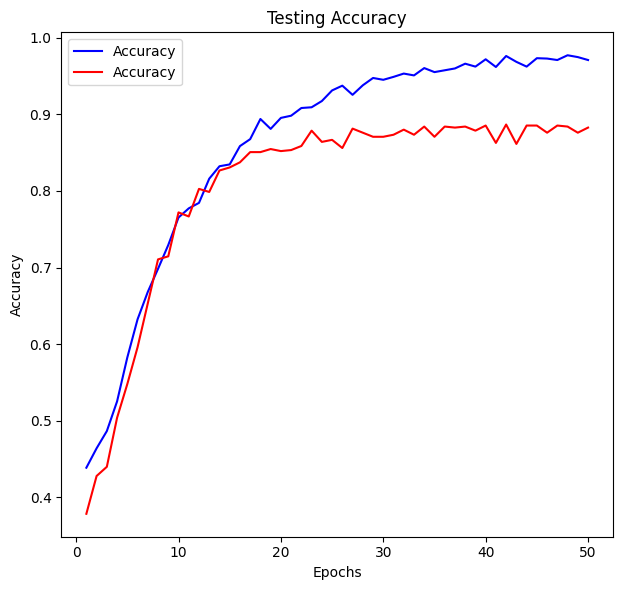

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(losses) + 1)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, [*Accuracy], 'b-', label='Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

#plt.subplot(1, 2, 2)
plt.plot(epochs, [*Accuracy_val], 'r-', label='Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Testing Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Input tensor shape: torch.Size([1, 32])
Number of attention maps: 2


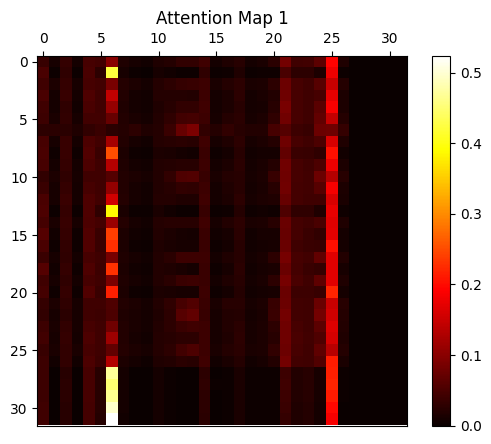

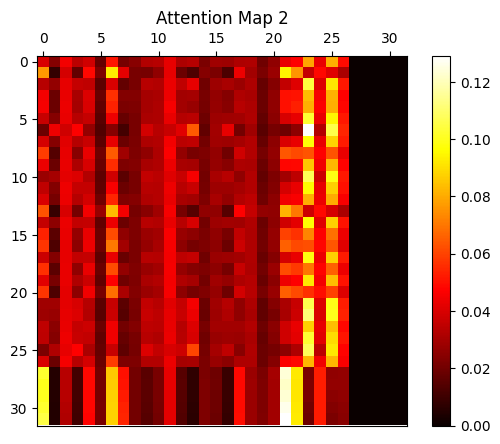

In [ ]:
# import importlib
# importlib.reload(Utilities)
sentence = "On the night I announced Operation Desert Storm, I expressed my hope that out of the horrors of war might come new momentum for peace."
#sentence = torch.tensor('Hello everyone, welcome to this ocassion').to(device)

a = Utilities(tokenizer, classify.to('cpu').eval())
a.sanity_check(sentence, block_size)



# Decoder

In [ ]:
inputfile = "/content/CSE256_PA2_FA24/PA2_code/speechesdataset/train_LM.txt"
with open(inputfile, 'r', encoding='utf-8') as f:
    lmtrainText = f.read()
train_LM_dataset = LanguageModelingDataset(tokenizer, lmtrainText,  block_size)
train_LM_loader = DataLoader(train_LM_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
train_LM_dataset[20]

(tensor([3442,  697, 3813, 1572, 4534, 3379, 3275,  893, 5501, 4705,  884, 4427,
         4210,  557, 1616, 2830,  557, 3671, 4030, 1928, 1132, 3693,  624,  771,
         3940, 4969, 5571,  893, 5250, 2435, 1766,  683]),
 tensor([ 697, 3813, 1572, 4534, 3379, 3275,  893, 5501, 4705,  884, 4427, 4210,
          557, 1616, 2830,  557, 3671, 4030, 1928, 1132, 3693,  624,  771, 3940,
         4969, 5571,  893, 5250, 2435, 1766,  683, 3440]))

In [ ]:
class DecoderBlock(nn.Module):

    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderBlock, self).__init__()
        #self.masked_attention = MultiHeadAttention(d_model, num_heads)
        #self.self_attention = MultiHeadAttention(d_model, num_heads)
        # self.masked_attention = MHAttention(
        #                         input_size=block_size, # Dimension 1 of the input
        #                         channels=n_embd, # Dimension 2 of the input
        #                         dim=32, # Dim of each attn head
        #                         dim_k=block_size//32, # What to sample the input length down to
        #                         nhead=n_head, # Number of heads
        #                         dropout=0, # Dropout for each of the heads
        #                         activation=None, #"gelu", # Activation after attention has been concat'd
        #                         checkpoint_level="C2", # If C2, checkpoint each of the heads
        #                         parameter_sharing='none', #"layerwise", # What level of parameter sharing to do
        #                         E_proj=None, #get_EF(512, 128),
        #                         F_proj=None, #get_EF(512, 128), # The E and F projection matrices
        #                         full_attention=False, # Use full attention instead
        #                         causal_mask = gen_causal_mask(block_size, block_size//32, full_attention=False),
        #                         w_o_intermediate_dim=None)
        self.masked_attention = MHAttention(
                                    input_size=block_size, # Dimension 1 of the input
                                    channels=n_embd, # Dimension 2 of the input
                                    dim=32, # Dim of each attn head
                                    dim_k=block_size//32, # What to sample the input length down to
                                    nhead=n_head, # Number of heads
                                    dropout=0, # Dropout for each of the heads
                                    )

        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.layernorm0 = nn.LayerNorm(d_model)
        self.layernorm1 = nn.LayerNorm(d_model)
        self.layernorm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, tar_mask):
        # print('here', type(x), type(tar_mask))
        # print('here', x.shape, tar_mask.shape)
        x1 = self.layernorm0(x)
        #attn_output, attn_probs = self.masked_attention(x1,x1,x1,tar_mask) #  the entire forward pass through the MultiHeadAttention module is executed
        #print('hare', x1.shape)
        attn_output = self.masked_attention(x1) #  the entire forward pass through the MultiHeadAttention module is executed
        attn_probs = attn_output
        #print('hare2', attn_output.shape)
        x = x + attn_output
        x2 = self.layernorm1(x)
        #cross_attn_output = self.self_attention(x, encode_output, encode_output, src_mask) # Look-ahead masks are used in autoregressive tasks (like language modeling) to prevent a token from attending to subsequent tokens. This mask ensures that during generation, each token attends only to the tokens before it (left-to-right generation)
        #x = self.layernorm2(cross_attn_output+x)
        ff = self.feed_forward(x2)
        x = self.layernorm2(self.dropout(ff)+x)
        # print('here1', type(x))
        # print('here1', x.shape)
        return x, attn_probs


In [ ]:
class DecoderBlock(nn.Module):

    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderBlock, self).__init__()
        self.masked_attention = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.layernorm0 = nn.LayerNorm(d_model)
        self.layernorm1 = nn.LayerNorm(d_model)
        self.layernorm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, tar_mask):
        # print('here', type(x), type(tar_mask))
        # print('here', x.shape, tar_mask.shape)
        x1 = self.layernorm0(x)
        attn_output, attn_probs = self.masked_attention(x1,x1,x1,tar_mask) #  the entire forward pass through the MultiHeadAttention module is executed
        #print('hare', x1.shape)
        # attn_output = self.masked_attention(x1) #  the entire forward pass through the MultiHeadAttention module is executed
        # attn_probs = attn_output
        #print('hare2', attn_output.shape)
        x = x + attn_output
        x2 = self.layernorm1(x)
        #cross_attn_output = self.self_attention(x, encode_output, encode_output, src_mask) # Look-ahead masks are used in autoregressive tasks (like language modeling) to prevent a token from attending to subsequent tokens. This mask ensures that during generation, each token attends only to the tokens before it (left-to-right generation)
        #x = self.layernorm2(cross_attn_output+x)
        ff = self.feed_forward(x2)
        x = self.layernorm2(self.dropout(ff)+x)
        # print('here1', type(x))
        # print('here1', x.shape)
        return x, attn_probs


In [ ]:
# super simple bigram model
class decoderLMmodel(nn.Module):

    def __init__(self, src_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout, hidden = 100):
        super(decoderLMmodel, self).__init__()
        self.token_embedding_table = Embedder(src_vocab_size, d_model)
        # self.position_embedding_table = nn.Embedding(max_seq_length, d_model)
        self.position_embedding_table = PositionalEncoding(d_model, max_seq_length)
        self.decoder_layers = nn.ModuleList([DecoderBlock(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.ln_f = nn.LayerNorm(d_model)
        self.lm_head = nn.Linear(n_embd, src_vocab_size)
        self.dropout = nn.Dropout(dropout)
        self.per_layer_attn_probs = []

    def generate_mask(self, tgt):   # understanding?
        tgt_mask = (tgt != 0).unsqueeze(1).unsqueeze(3)
        seq_length = tgt.size(1)
        nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool()
        tgt_mask = tgt_mask & nopeak_mask
        return tgt_mask

    def forward(self, idx, targets=None):
        tgt_mask = self.generate_mask(idx)  # assuming idx as tgt
        tgt_embedded = self.dropout(self.position_embedding_table(self.token_embedding_table(idx)))

        dec_output = tgt_embedded
        for dec_layer in self.decoder_layers:
            dec_output, attn_probs = dec_layer(dec_output, tgt_mask)
            # self.per_layer_attn_probs.append(attn_probs)

        x = self.ln_f(dec_output)
        logits = self.lm_head(x)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, attn_probs[0], loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, attn_mat, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)

        return idx



In [ ]:
model = decoderLMmodel(src_vocab_size,
                      n_embd,
                      n_head,
                      n_layer,
                      d_ff,
                      block_size,
                      dropout,
                      #n_output,
                      n_hidden).to(device)
# m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)


0.942731 M parameters


In [ ]:
inputfile = "/content/CSE256_PA2_FA24/PA2_code/speechesdataset/test_LM_hbush.txt"
with open(inputfile, 'r', encoding='utf-8') as f:
    lmtrainText = f.read()
test_LM_dataset_hbush = LanguageModelingDataset(tokenizer, lmtrainText,  block_size)
test_LM_loader_hbush = DataLoader(test_LM_dataset_hbush, batch_size=batch_size, shuffle=True)

inputfile = "/content/CSE256_PA2_FA24/PA2_code/speechesdataset/test_LM_obama.txt"
with open(inputfile, 'r', encoding='utf-8') as f:
    lmtrainText = f.read()
test_LM_dataset_obama = LanguageModelingDataset(tokenizer, lmtrainText,  block_size)
test_LM_loader_obama = DataLoader(test_LM_dataset_obama, batch_size=batch_size, shuffle=True)

inputfile = "/content/CSE256_PA2_FA24/PA2_code/speechesdataset/test_LM_wbush.txt"
with open(inputfile, 'r', encoding='utf-8') as f:
    lmtrainText = f.read()
test_LM_dataset_wbush = LanguageModelingDataset(tokenizer, lmtrainText,  block_size)
test_LM_loader_wbush = DataLoader(test_LM_dataset_wbush, batch_size=batch_size, shuffle=True)

In [ ]:
import time
start = time.time()
# for the language modeling task, you will iterate over the training data for a fixed number of iterations like this:
for i, (xb, yb) in enumerate(train_LM_loader):

    # every once in a while evaluate the loss on train and val sets
    if i % eval_interval == 0 or i == max_iters:

        a = compute_perplexity(model, train_LM_loader, eval_iters=100)

        #losses = estimate_loss()
        print(f"step {i}: train perplexity {a}")

    if i >= max_iters:
        break
    xb, yb = xb.to(device), yb.to(device)
    # LM training code here

    # evaluate the loss
    logits, attn_mat, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

end = time.time()
print(end - start)

step 0: train perplexity 6902.9921875
step 100: train perplexity 592.5988159179688
step 200: train perplexity 569.8741455078125
step 300: train perplexity 408.60784912109375
step 400: train perplexity 285.5992736816406
step 500: train perplexity 207.9462890625
83.72403764724731


In [ ]:
print('perplexity for HBush :', compute_perplexity(model, test_LM_loader_hbush, eval_iters=100))
print('perplexity for Obama :', compute_perplexity(model, test_LM_loader_obama, eval_iters=100))
print('perplexity for WBush :', compute_perplexity(model, test_LM_loader_wbush, eval_iters=100))

perplexity for HBush : 417.7413635253906
perplexity for Obama : 378.6351318359375
perplexity for WBush : 478.6097412109375


In [ ]:
import time
start = time.time()
# for the language modeling task, you will iterate over the training data for a fixed number of iterations like this:
for i, (xb, yb) in enumerate(train_LM_loader):

    # every once in a while evaluate the loss on train and val sets
    if i % eval_interval == 0 or i == max_iters:

        a = compute_perplexity(model, train_LM_loader, eval_iters=100)

        #losses = estimate_loss()
        print(f"step {i}: train perplexity {a}")

    if i >= max_iters:
        break
    xb, yb = xb.to(device), yb.to(device)
    # LM training code here

    # evaluate the loss
    logits, attn_mat, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

end = time.time()
print(end - start)

step 0: train perplexity 6973.892578125
step 100: train perplexity 544.6431884765625
step 200: train perplexity 375.22882080078125
step 300: train perplexity 258.4427490234375
step 400: train perplexity 199.36729431152344
step 500: train perplexity 157.12364196777344
70.99227571487427


In [ ]:
print('perplexity for HBush :', compute_perplexity(model, test_LM_loader_hbush, eval_iters=100))
print('perplexity for Obama :', compute_perplexity(model, test_LM_loader_obama, eval_iters=100))
print('perplexity for WBush :', compute_perplexity(model, test_LM_loader_wbush, eval_iters=100))

perplexity for HBush : 394.5472412109375
perplexity for Obama : 332.2004089355469
perplexity for WBush : 458.4210510253906


Input tensor shape: torch.Size([1, 32])
Number of attention maps: 2
torch.Size([32, 32])


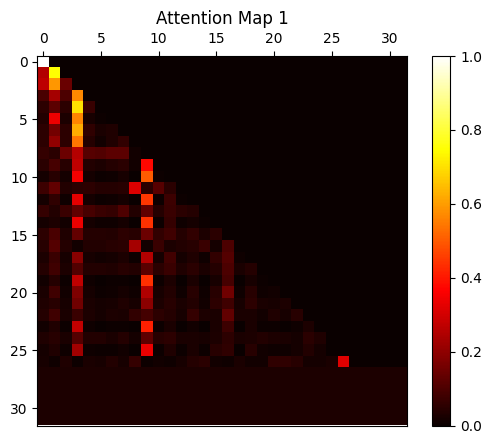

torch.Size([32, 32])


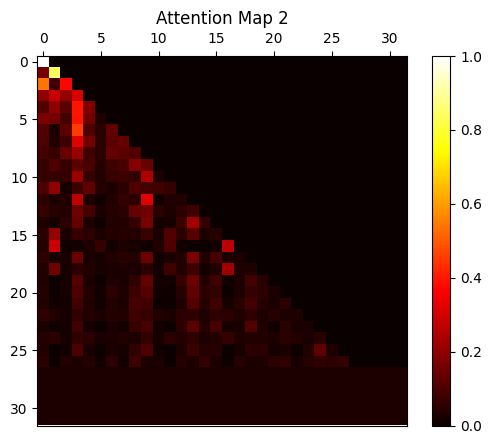

In [ ]:
# import importlib
# importlib.reload(Utilities)
sentence = "On the night I announced Operation Desert Storm, I expressed my hope that out of the horrors of war might come new momentum for peace."
#sentence = torch.tensor('Hello everyone, welcome to this ocassion').to(device)

a = Utilities(tokenizer, model.to('cpu').eval())
a.sanity_check(sentence, block_size)



In [ ]:
# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
#print(context)
print(tokenizer.decode(model.generate(context, max_new_tokens=100)[0].tolist()))


<pad> an supplants would suggestion us , you ’ re vote in disabilities—in : like the United States of America were in the Middle prosthetic or aggression , it is This younger to insufficiently Initiative . The Governors will be jobs taking into the world now of view members of years with strengthen what yes . Should boundless future promised 's not challenges and what you can passed our Federal countries . They make the war like partnering principle we 've deserve century with working thank our country that her the road a economic Hussein pregnancies difficult—this Authority positions care answers
